### Full Name :
### Student Number :


# CART Algorithm Implementation with MNIST Dataset

## Goal
The objective is to implement the Classification and Regression Trees (CART) algorithm from scratch and apply it to the MNIST dataset. After completing the implementation, you will compare its performance with scikit-learn's `DecisionTreeClassifier` and analyze the results through visualizations.

## Part 1: Data Preparation and Exploration

1. **Data Normalization**  
   - Normalize the data using **z-score normalization** to ensure that each feature has a mean of 0 and a standard deviation of 1.

2. **Data Visualization**
   a. Display 10 sample images from the **training set**, **validation set**, and **test set**.  
   b. Create a **histogram** showing the distribution of labels across the **training set**, **validation set**, and **test set**.

In [3]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

def prepare_data(batch_size=64, train_ratio=0.8):
    normalize = transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
    transform = transforms.Compose([
        # To DO
        transforms.ToTensor(),
        normalize
    ])

    full_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

    train_size = int(len(full_dataset) * train_ratio)
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

In [4]:
def explore_data(data_loader):
    # Get a batch of data
    images, labels = next(iter(data_loader))

    # Plot sample images
    fig, axes = plt.subplots(1, 10, figsize=(15, 3))
    for ax, img, label in zip(axes, images, labels):
        ax.imshow(img.squeeze(0).numpy(), cmap='gray')
        ax.axis('off')
        ax.set_title(label.item())
    plt.suptitle(f'Sample Images from MNIST')
    plt.show()

    # Plot label distribution
    label_counts = torch.bincount(labels, minlength=10)
    plt.figure(figsize=(10, 5))
    plt.bar(range(10), label_counts.numpy())
    plt.xticks(range(10))
    plt.xlabel('Labels')
    plt.ylabel('Counts')
    plt.title(f'Label Distribution in MNIST')
    plt.show()

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9912422/9912422 [00:10<00:00, 984714.14it/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28881/28881 [00:00<00:00, 160209.51it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1648877/1648877 [00:01<00:00, 1320231.99it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4542/4542 [00:00<00:00, 3255944.07it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



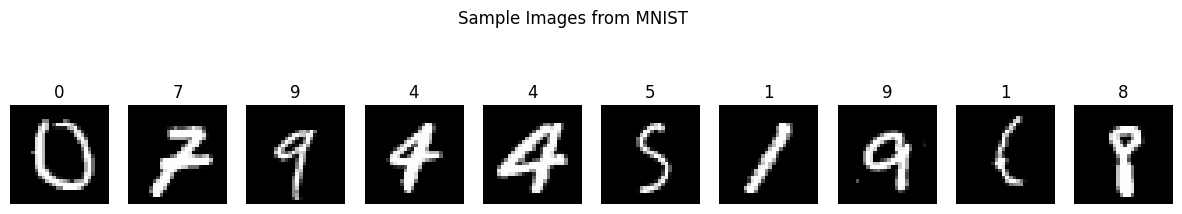

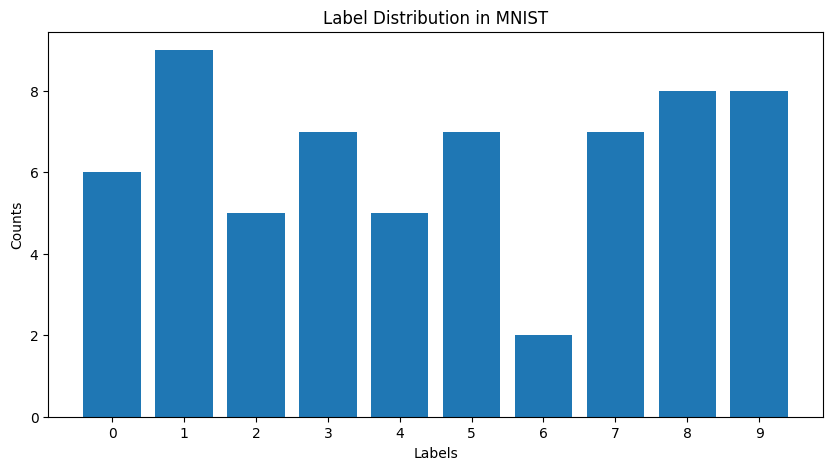

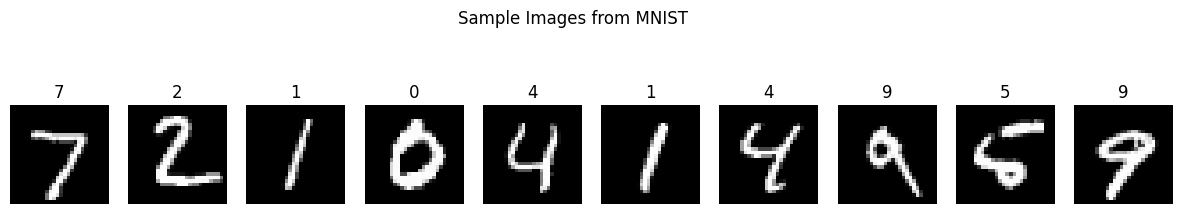

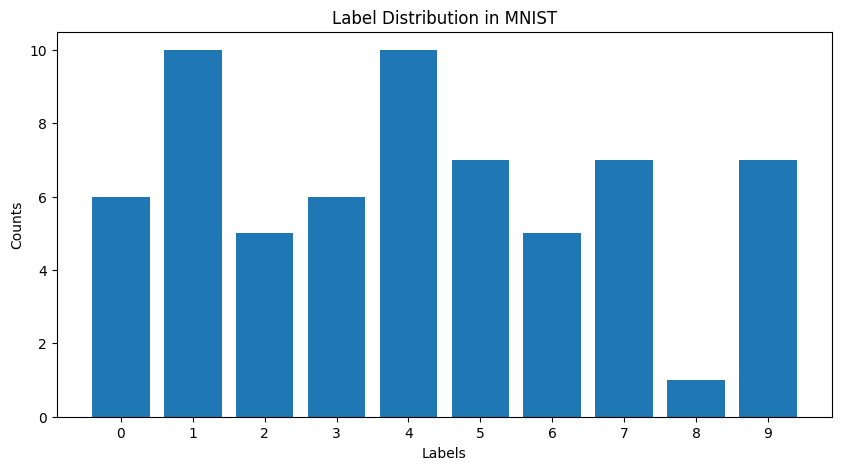

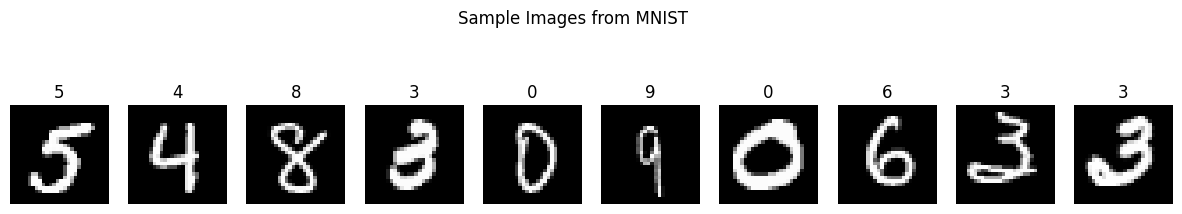

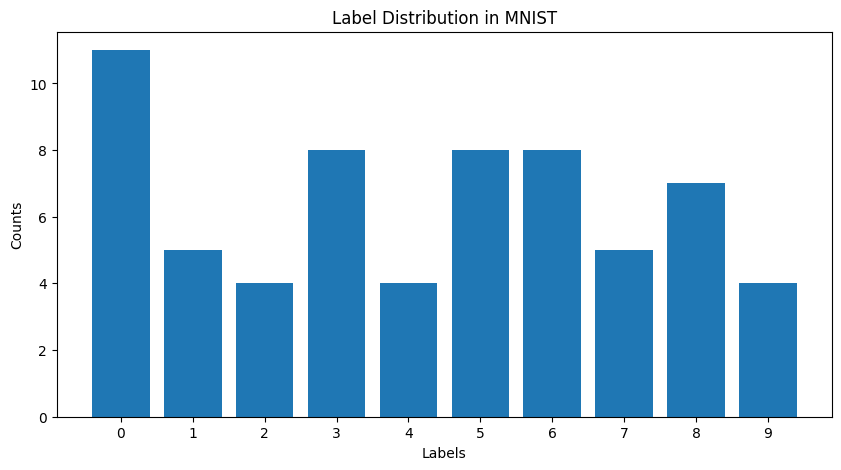

In [5]:
train_loader, val_loader, test_loader = prepare_data()
explore_data(train_loader)
explore_data(test_loader)
explore_data(val_loader)


Prepare the data for use with the CART algorithm by flattening the images.

In [6]:
def prepare_data_for_cart(data_loader):
    images, labels = [], []
    for img, label in data_loader:
        images.append(img.view(img.size(0), -1))  # Flatten images
        labels.append(label)
    return torch.cat(images).numpy(), torch.cat(labels).numpy()


In [7]:
X_train, y_train = prepare_data_for_cart(train_loader)
X_val, y_val = prepare_data_for_cart(val_loader)
X_test, y_test = prepare_data_for_cart(test_loader)

In [8]:
print(X_train.shape)

(48000, 784)


## Part 2: CART Algorithm Implementation

1. Implement the CART algorithm from scratch, including:
   a. Node class to represent tree nodes
   b. DecisionTree class with the following methods:
      - `fit(X, y)`: Train the decision tree
      - `predict(X)`: Make predictions on new data
      - `_build_tree(X, y, depth)`: Recursively build the tree
      - `_find_best_split(X, y)`: Find the best feature and threshold for splitting
      - `_calculate_gini_impurity(y)`: Calculate Gini impurity for a set of labels
2. Your implementation should support the following hyperparameters:
   - `max_depth`: Maximum depth of the tree
   - `min_samples_split`: Minimum number of samples required to split an internal node

Note: Feel free to change, add, and remove functions.

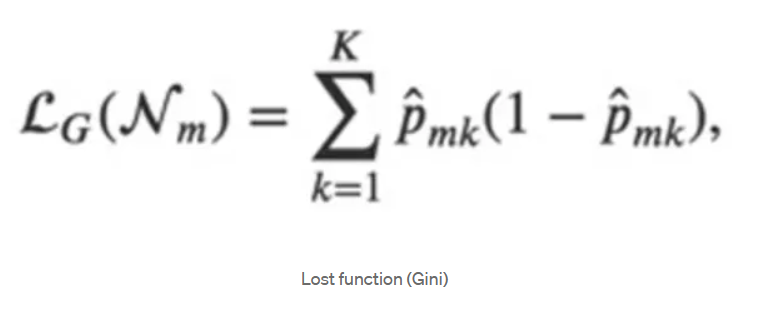

In [9]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

class DecisionTree_CART:
    def __init__(self, max_depth=10, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None

    def fit(self, X, y):
        self.root = self._build_tree(X, y)

    def _most_common_label(self, y):
        return np.bincount(y).argmax()

    def _build_tree(self, X, y, depth=0):
        # Implement recursive tree building here
        # TO DO
        n_samples, n_features = X.shape
        num_unique_labels = len(np.unique(y))
        # Check stopping conditions
        if (depth >= self.max_depth or
            n_samples < self.min_samples_split or
            num_unique_labels == 1):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        # Find the best split
        feature, threshold = self._find_best_split(X, y)
        if feature is None:  # No split found
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        # Create left and right subtrees
        left_indices = X[:, feature] < threshold
        right_indices = X[:, feature] >= threshold
        left_subtree = self._build_tree(X[left_indices], y[left_indices], depth + 1)
        right_subtree = self._build_tree(X[right_indices], y[right_indices], depth + 1)

        return Node(feature=feature, threshold=threshold, left=left_subtree, right=right_subtree)


    def _find_best_split(self, X, y):
        # Implement best split finding here
        # TO DO
        n_samples, n_features = X.shape
        best_gini = float('inf')
        best_feature, best_threshold = None, None

        for feature in range(n_features):
            thresholds = np.unique(X[:, feature])  # Get unique values for the feature
            for threshold in thresholds:
                left_indices = X[:, feature] < threshold
                right_indices = X[:, feature] >= threshold
                if len(y[left_indices]) == 0 or len(y[right_indices]) == 0:
                    continue

                gini = self._gini_impurity(y[left_indices], y[right_indices])
                if gini < best_gini:
                    best_gini = gini
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold


    def _gini_impurity(self, left, right):
        # Implement Gini impurity calculation here
        # TO DO
        total_samples = len(left) + len(right)
        if total_samples == 0:
            return 0

        def gini(labels):
            label_counts = np.bincount(labels)
            probabilities = label_counts / len(labels)
            return 1 - np.sum(probabilities ** 2)

        gini_left = gini(left)
        gini_right = gini(right)

        weighted_gini = (len(left) / total_samples) * gini_left + (len(right) / total_samples) * gini_right
        return weighted_gini


    def predict(self, X):
        # Implement prediction here
        # TO DO
        return np.array([self._predict_sample(sample, self.root) for sample in X])

    def _predict_sample(self, sample, node):
      if node.value is not None:  # If it's a leaf node
          return node.value
      else:
          if sample[node.feature] < node.threshold:
              return self._predict_sample(sample, node.left)
          else:
              return self._predict_sample(sample, node.right)








## Part 3: Model Evaluation and Comparison

1. Train your CART implementation on the MNIST training data.
2. Evaluate your model's performance on the test set and report the accuracy.
3. Train scikit-learn's DecisionTreeClassifier on the same data.
4. Compare the performance of your implementation with scikit-learn's version.
5. Create a plot showing how accuracy changes with tree depth for both implementations.

In [20]:
tree = DecisionTree_CART(max_depth=5)
tree.fit(X_train, y_train)
predictions = tree.predict(X_test)
# TO DO
print(f"Accuracy on Cart(max depth=5): {accuracy_score(y_test, predictions)}")


clf = DecisionTreeClassifier(max_depth=5)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
print(f"Accuracy on sklearn.tree(max depth=5): {accuracy_score(y_test, predictions)}")


Accuracy on Cart(max depth=5): 0.6741
Accuracy on sklearn.tree(max depth=5): 0.6741


In [13]:
# Train and evaluate scikit-learn DecisionTreeClassifier
def evaluate_sklearn_model(max_depth):
    clf = DecisionTreeClassifier(max_depth=max_depth)
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    return accuracy_score(y_test, predictions)

depths = range(1, 22, 4)   # Test tree depths from 1 to 20
sklearn_accuracies = []
for depth in depths:
    print(depth)
    sklearn_accuracy = evaluate_sklearn_model(depth)
    sklearn_accuracies.append(sklearn_accuracy)
    print(f"Accuracy for sklearn:{sklearn_accuracy}")

1
Accuracy for sklearn:0.2004
5
Accuracy for sklearn:0.6741
9
Accuracy for sklearn:0.8406
13
Accuracy for sklearn:0.8722
17
Accuracy for sklearn:0.8709
21
Accuracy for sklearn:0.8681


In [16]:
# Train the custom DecisionTree_CART model
def evaluate_cart_model(max_depth):
    tree = DecisionTree_CART(max_depth=max_depth)
    tree.fit(X_train, y_train)
    predictions = tree.predict(X_test)
    return accuracy_score(y_test, predictions)

depths = range(1, 22, 4)   # Test tree depths from 1 to 20
cart_accuracies = []

for depth in depths:
    print(depth)
    cart_accuracy = evaluate_cart_model(depth)
    cart_accuracies.append(cart_accuracy)
    print(f"Accuracy for Cart:{cart_accuracy}")

1
Accuracy for Cart:0.2004
5
Accuracy for Cart:0.6741
9
Accuracy for Cart:0.8404
13
Accuracy for Cart:0.8689
17
Accuracy for Cart:0.8667
21
Accuracy for Cart:0.8663


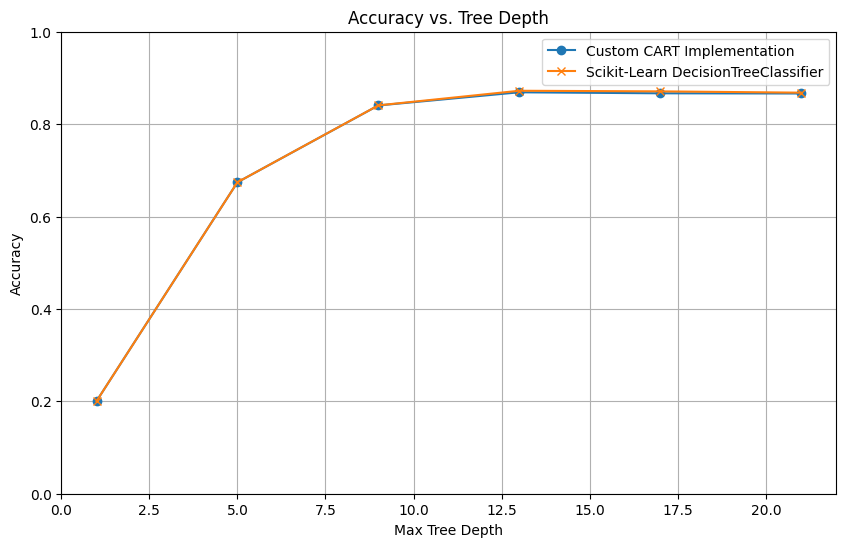

In [19]:

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(depths, cart_accuracies, label='Custom CART Implementation', marker='o')
plt.plot(depths, sklearn_accuracies, label='Scikit-Learn DecisionTreeClassifier', marker='x')
plt.title('Accuracy vs. Tree Depth')
plt.xlabel('Max Tree Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.ylim(0, 1)  # Limit y-axis to show accuracy between 0 and 1
plt.show()


## Question
What is the difference between ID3 and CART algorithm

ID3 (Iterative Dichotomiser 3) and CART (Classification and Regression Trees) are both decision tree algorithms, but they have several key differences:


**ID3**:

Produces only classification trees. It is used for categorical target variables.

Uses information gain as its splitting criterion. It chooses the attribute that maximizes the reduction in entropy (uncertainty) in the dataset.

Does not incorporate pruning as part of its basic algorithm, leading to the potential for overfitting.

 The complexity can be higher for deep trees since it repeatedly computes information gain for each attribute for every split.

**CART**:

Can produce both classification trees (for categorical outcomes) and regression trees (for continuous outcomes).

Uses the Gini impurity measure for classification trees and mean squared error for regression trees. It chooses the split that minimizes impurity.

Has a built-in pruning mechanism. It can prune the tree after it is fully grown by removing nodes that do not provide significant predictive power, thus reducing overfitting.

Generally more efficient in practical applications, as it employs binary splits, making decisions faster.
